In [2]:
%config InlineBackend.figure_formats = {"retina", "png"} # Mostar imágenes formato png y con alta resolución
# Las graficas se muestren en el notebook y no en una ventana emergente
%matplotlib inline

import os # Crea carpetas o rutas
import tempfile # Crea archivos o carpetas temporales que se eliminan automaticamente
from typing import List, Tuple # Anotaciones de tipo (mejora legibilidad y depuración del código)

os.environ["OPENBLAS_NUM_THREADS"] = "1" # Limita el numero de hilos1 a 1. Evita que el código use muchos nucleos y sobrecargue el sistema

# CREAR ANIMACIONES
from IPython.display import HTML, display
# display(): Muestra gráficos, animaciones, html, widgets, etc
# HTML(): Permite inscrustar código HTML directamente en la celda (para mostrar una animación)
import h5py # Lee y escribe archivos .h5, los cuales almacenan una gran cantidad de datos
from tdgl.visualization.animate import create_animation


import numpy as np
import matplotlib as mpl
from matplotlib.path import Path # Define curvas o contornos personalizados
from matplotlib.textpath import TextPath # Convierte texto en trayectorias gráficas (crea letras como curvas)
from matplotlib.font_manager import FontProperties # Permite usar fuentes específicas
import matplotlib.pyplot as plt

# CONFIGURACION DE ESTILO GRÁFICO
plt.rcParams["figure.figsize"] = (5, 4) # Tamaño de las figuras (ancho, alto)
plt.rcParams["font.size"] = 11 # Tamaño de la letra en las gráficas

# PAQUETE TDGL
import tdgl
from tdgl.geometry import box, circle, ensure_unique, close_curve
# box: Crea una caja (dominio rectangular) para la simulación
# ensure_unique: Asegura que los puntos de una curva no se repitan (importante en mallas)
# close_curve: Cierra una curva suavemente (para trayectorias cerradas como letras)
from tdgl.sources import LinearRamp, ConstantField
# LinearRamp: Campo magnetico que aumenta linealmente con el tiempo
# ConstanteField: Campo magnético constante

# PARÁMETROS DE EJECUCIÓN
USE_TEMPDIR = True # Se usará un directorio temporal para guardar imágenes si es TRUE
SAVE = True # Se guardarán las imágnes que se generen
MAKE_ANIMATIONS = True # Genera animaciones de la evolución del sistema
image_path = os.path.join(os.pardir, "images") # Define el path donde se guardarán las imágenes. os.pardir significa “directorio padre”, así que esto apunta a ../images

if USE_TEMPDIR:
    tempdir = tempfile.TemporaryDirectory()
    output_path = tempdir.name
else:
    output_path = "."

# Función para generar un video HTML a partir de una solución TDGL previamente simulada

In [3]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

# Defining the device (GEOMETRÍA Y PROPIEDADES DEL SISTEMA)

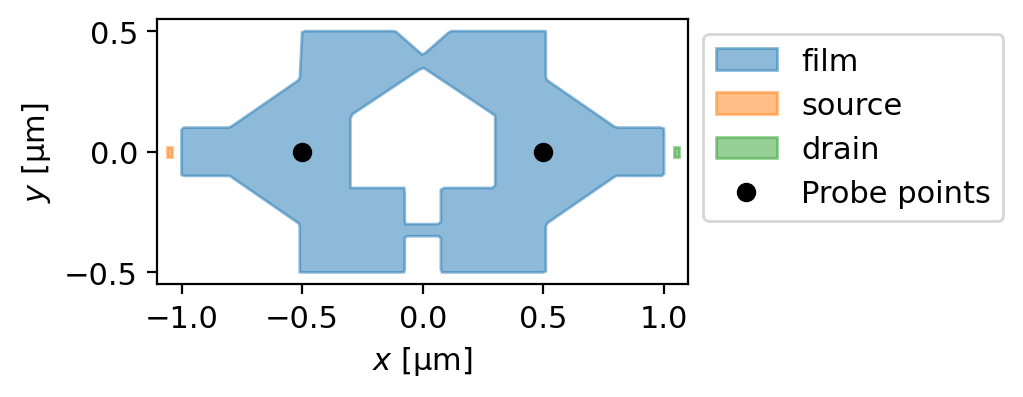

In [11]:
length_units = "um" # Longitud en micrómetros

# PARÁMETROS DEL MATERIAL
xi = 0.5 # Longitud de coherencia GL
london_lambda = 2 # Longitud de penetración de London \lambda
d = 0.1 # Espesor de la película semiconductora en micrómetros
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1) # Se crea el objeto "layer" que describe el material
# gamma = 1 -> Parámetro proporcional al inelastic scattering time y al tamaño del gap superconductor

# ------------------------------------ GEOMETRÍA ------------------------
# GEOMETRÍA DEL SUPERCONDUCTOR
total_width = 2 # Ancho total de la película
total_length = 1 # Largo total de la película
link_width = total_width / 3 # Ancho de un canal o cuello entre las regiones

# MUESCAS
# Cuadrado
polygon2_points = [(0.075, -0.35), (-0.075, -0.35), (-0.075,-0.51), (0.075, -0.51), (0.075, -0.35)]  # último punto igual al primero para cerrarlo
polygon2_hole = tdgl.Polygon("polygon2_hole", points=polygon2_points)

# Triangulo invertido
polygon3_points = [(-0.125, 0.51), (0, 0.4), (0.125, 0.51), (-0.125, 0.51)]  # último punto igual al primero para cerrarlo
polygon3_hole = tdgl.Polygon("polygon3_hole", points=polygon3_points)

# Poligono superior izquierda
polygon4_points = [(-0.51, 0.3), (-0.5, 0.5), (-1.1,0.51), (-1.1, 0.1), (-0.8, 0.1), (-0.51, 0.3)]  # último punto igual al primero para cerrarlo
polygon4_hole = tdgl.Polygon("polygon4_hole", points=polygon4_points)

# Poligono superior derecha
polygon5_points = [(1.1, 0.51), (0.51, 0.51), (0.51, 0.3), (0.8, 0.1), (1.1, 0.1), (1.1, 0.51)]  # último punto igual al primero para cerrarlo
polygon5_hole = tdgl.Polygon("polygon5_hole", points=polygon5_points)

# Poligono inferior izquierda
polygon6_points = [(-0.51, -0.3), (-0.8, -0.1), (-1.1, -0.1), (-1.1, -0.51), (-0.51, -0.51), (-0.51, -0.3)]  # último punto igual al primero para cerrarlo
polygon6_hole = tdgl.Polygon("polygon6_hole", points=polygon6_points)

# Poligono inferior derecha
polygon7_points = [(1.1, -0.51), (1.1, -0.1), (0.8, -0.1), (0.51, -0.3), (0.51, -0.51), (1.1, -0.51)]  # último punto igual al primero para cerrarlo
polygon7_hole = tdgl.Polygon("polygon7_hole", points=polygon7_points)


# Pelicula -> Caja rectangular
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(polygon2_hole, polygon3_hole, polygon4_hole, polygon5_hole, polygon6_hole, polygon7_hole)
    .resample(401)
    .buffer(0)
)


# AGUJEROS EN LA PELÍCULA
polygon1_points = [(0.3, 0.2), (0, 0.4), (-0.3, 0.2), (-0.3, -0.1), (-0.075, -0.1), (-0.075, -0.25), (0.075, -0.25), (0.075, -0.1), (0.3, -0.1), (0.3, 0.2)]  # último punto igual al primero para cerrarlo
polygon1_hole = (
    tdgl.Polygon("polygon1_hole", points=polygon1_points)
    .translate(dy=-0.05)
    .resample(101)
) 


# TERMINALES DE CORRIENTE -> Para aplicar una corriente a travé de uno o más terminales en el dispositivo
# Terminal de corriente (como un contacto eléctrico) que se coloca arriba. Tiene el ancho del film y una altura delgada (total_length / 100)
source = (
    tdgl.Polygon("source", points=box(total_width / 100, 0.04)) # Rectángulo box(ancho, alto) -> Un poco más ancho que la película pero con altura del 1% del alto de la película
    .translate(dx=-total_length - 0.05)
)
# Terminal opuesto, refleja source verticalmente (yfact=-1) y renombrado como "drain"
drain = source.scale(xfact=-1).set_name("drain") # Por donde sale la corriente

#  PUNTOS DE MEDICIÓN DE VOLTAJE -> Con esto, el potencial escalar y la fase son evaluados como una función del tiempo
# Define dos puntos simétricos donde se medirá la diferencia de potencial (voltaje)
# Están ubicados sobre el eje vertical (x=0), arriba y abajo del centro de la película
probe_points = [(-0.5, 0), (0.5, 0)]

# ---------------------------MODELO DEL SUPERCONDUCTOR-------------------
# Describe la función física del dispositivo
device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    holes=[polygon1_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

# Generación de la geometría del dispositivo
fig, ax = device.draw()

## Malla

Se genera la malla numérica sobre la cual se resolverá la ecuación de Ginzburg–Landau dependiente del tiempo (TDGL).

Se discretiza el dominio geométrico en pequeños elementos (triángulos o polígonos). Luego, en cada nodo (vértice) o celda se resuelve la ecuación diferencial.

Se puede especificar el número mínimo de vértices de la malla (min_points), y/o el máximo de las longitudes de los bordes (max_edge_length).

* Generalmente, los bordes en la malla deberían ser pequeños comparados con la longitud de coherencia ζ (en este caso ζ=xi=0.5)

Constructing Voronoi polygons: 100%|██████████| 1652/1652 [00:01<00:00, 869.77it/s] 


num_sites,1652
num_elements,2804
min_edge_length,9.262e-03
max_edge_length,9.892e-02
mean_edge_length,2.603e-02
min_area,5.286e-05
max_area,5.498e-03
mean_area,6.264e-04
coherence_length,5.000e-01
length_units,um


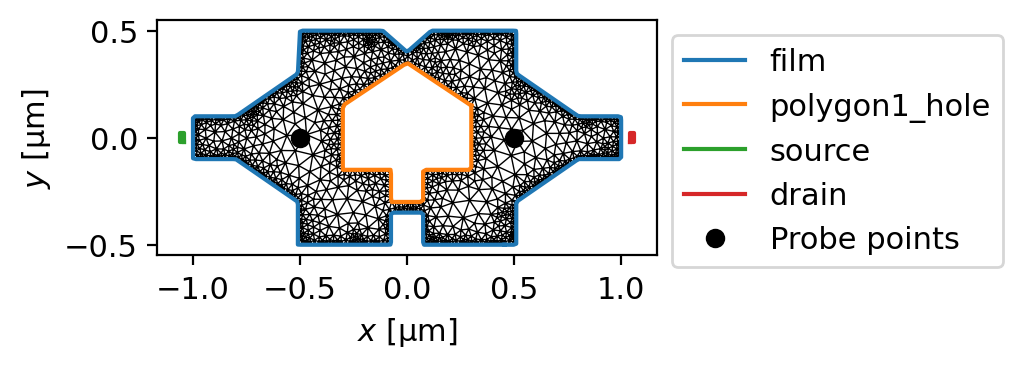

In [12]:
device.make_mesh(max_edge_length = xi / 2, smooth=100) # Genera una malla de elementos finitos que cubre el "device", la película superconductora
# smooth: Suaviza la malla, mejora la calidad geométrica de los triángulos (evita ángulos muy agudos o deformaciones). Entre mayor sea el smooth, más pasos de suavizado

# VIZUALIZAR EL DISPOSITIVO + MALLA
fig, ax = device.plot(mesh=True, legend=True)
# _ = ax.set_xlim(-4, -3)  # Ajuste rangos de los ejes
# _ = ax.set_ylim(-1, 1)  # Ajuste rangos de los ejes

device.mesh_stats() # Estadísticas de la malla (sites=nodos-vértices-, elements=triángulos)

# $J = 0$ y $H \neq 0$

In [6]:
options = tdgl.SolverOptions(
    solve_time=150,
    output_file=os.path.join(tempdir.name, "weak-link.h5"),
    field_units="mT",
    current_units="uA",
)

RAMP_FIELD = True

if RAMP_FIELD:
    from tdgl.sources import LinearRamp, ConstantField

    # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
    applied_vector_potential = (
        LinearRamp(tmin=0, tmax=100)
        * ConstantField(0.4, field_units=options.field_units, length_units=device.length_units)
    )
else:
    # If applied_vector_potential is given as a single number,
    # it is interpreted to mean the vector potential associated with a
    # uniform out-of-plane magnetic field with the specified strength.
    # This is simply shorthand for
    # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
    applied_vector_potential = 0.4

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

field_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=0.4,
    terminal_currents=dict(source=100, drain=-100),
    # The seed solution will be used as the initial state of the film.
    seed_solution=zero_current_solution,
)

Simulating: 100%|█████████▉| 150/150 [11:56<00:00,  4.78s/tau ]
Output file already exists. Renaming to C:\Users\Angelica\AppData\Local\Temp\tmpqj4v5nq2\weak-link-1.h5.
Simulating: 100%|█████████▉| 150/150 [01:25<00:00,  1.75tau/s ]


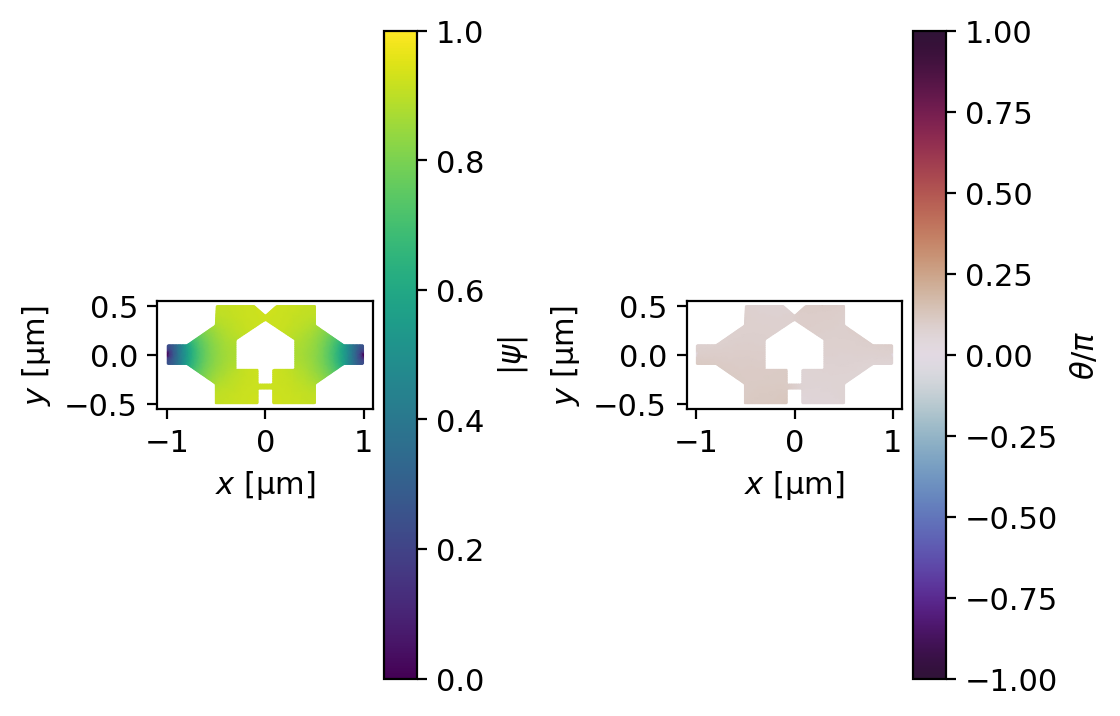

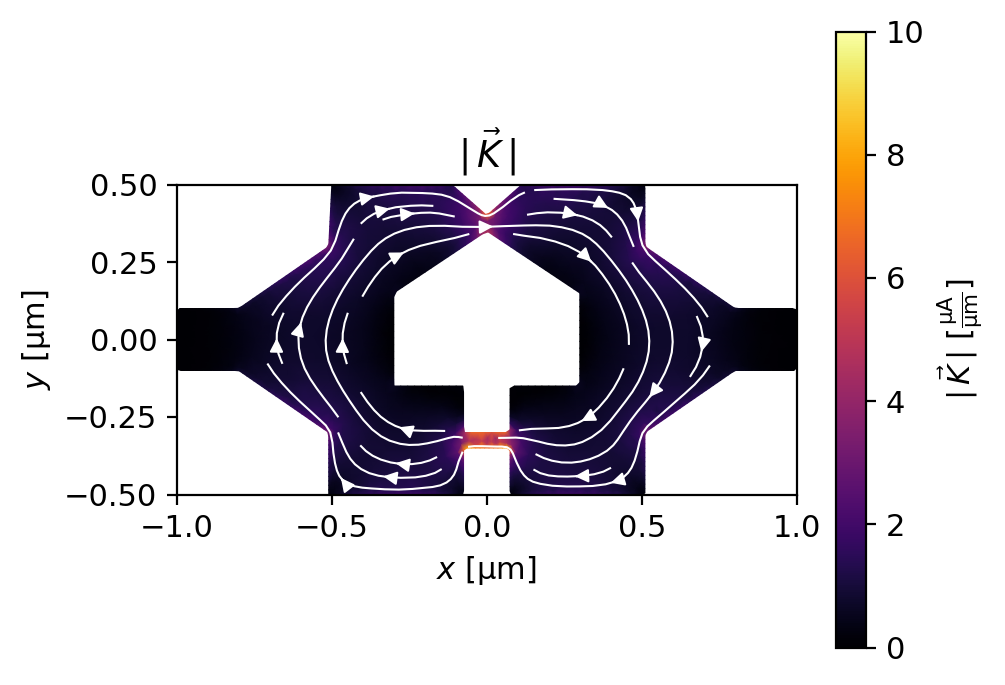

In [7]:
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 5.5))

fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=0, vmax=10)

# otro

Output file already exists. Renaming to C:\Users\Angelica\AppData\Local\Temp\tmpqj4v5nq2\weak-link-2.h5.
Simulating: 100%|█████████▉| 250/250 [14:49<00:00,  3.56s/tau ] 
Output file already exists. Renaming to C:\Users\Angelica\AppData\Local\Temp\tmpqj4v5nq2\weak-link-3.h5.
Simulating: 100%|█████████▉| 250/250 [02:31<00:00,  1.65tau/s ]


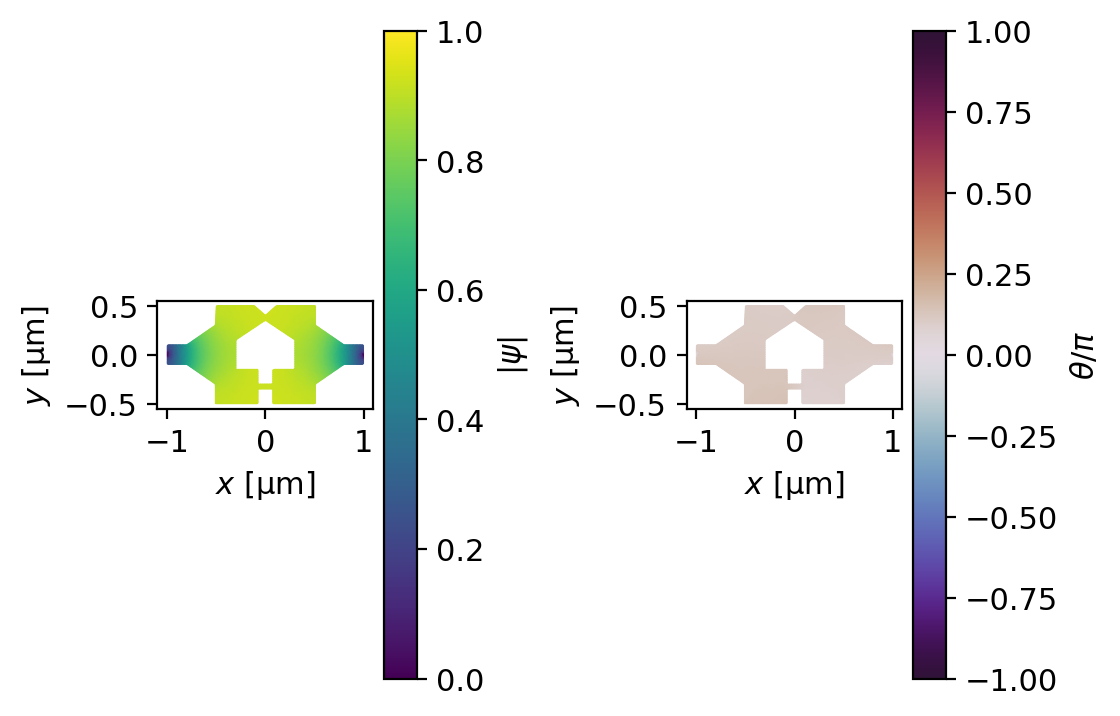

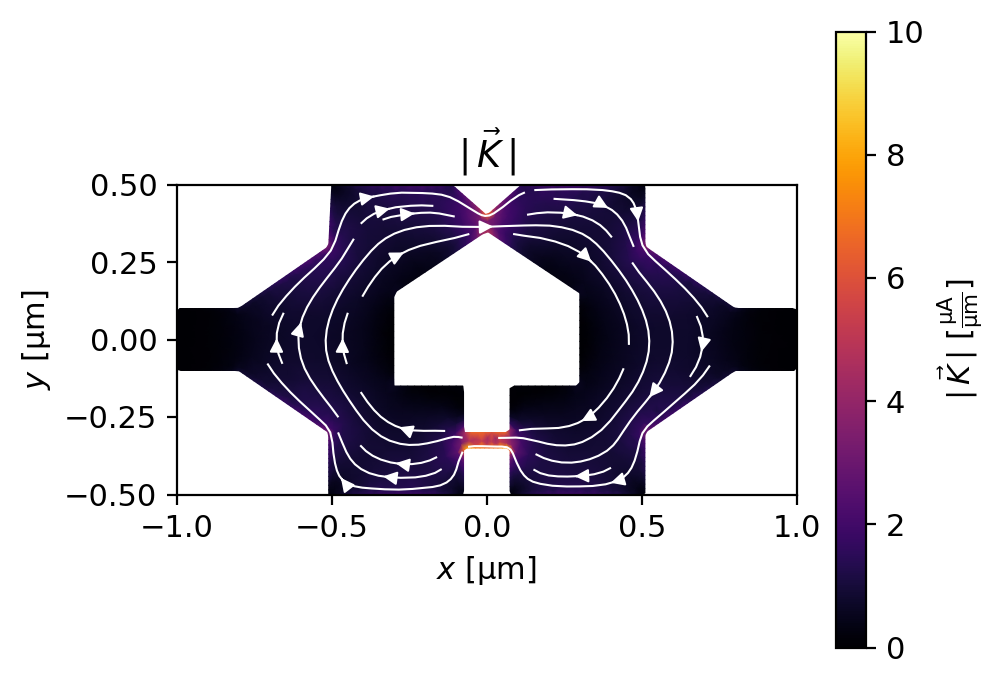

In [8]:
options = tdgl.SolverOptions(
    solve_time=250,
    output_file=os.path.join(tempdir.name, "weak-link.h5"),
    field_units="mT",
    current_units="uA",
)

RAMP_FIELD = True

if RAMP_FIELD:
    from tdgl.sources import LinearRamp, ConstantField

    # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
    applied_vector_potential = (
        LinearRamp(tmin=0, tmax=100)
        * ConstantField(0.4, field_units=options.field_units, length_units=device.length_units)
    )
else:
    # If applied_vector_potential is given as a single number,
    # it is interpreted to mean the vector potential associated with a
    # uniform out-of-plane magnetic field with the specified strength.
    # This is simply shorthand for
    # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
    applied_vector_potential = 0.8

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

field_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=0.8,
    terminal_currents=dict(source=100, drain=-100),
    # The seed solution will be used as the initial state of the film.
    seed_solution=zero_current_solution,
)

# GRAFICAS
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 5.5))

fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=0, vmax=10)